In [12]:
import cv2
import numpy as np

# Step 1: Load the image

image = cv2.imread('Rename.jpg')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to smooth the image
blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)

# Step 2: Detect circles using Hough Circle Transform
circles = cv2.HoughCircles(blurred_image, 
                           cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                           param1=50, param2=30, minRadius=50, maxRadius=150)

# Ensure at least some circle was found
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")

    # Create a mask for the circle
    mask = np.zeros_like(gray_image)

    # Get the first circle's coordinates
    for (x, y, r) in circles:
        # Draw the circle on the mask
        cv2.circle(mask, (x, y), r, 255, thickness=-1)

    # Step 3: Extract the region inside the circle
    segmented_image = cv2.bitwise_and(gray_image, gray_image, mask=mask)

    # Step 4: Display the original and segmented image
    cv2.imshow("Original Image", image)
    cv2.imshow("Segmented Image", segmented_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No circles were found")


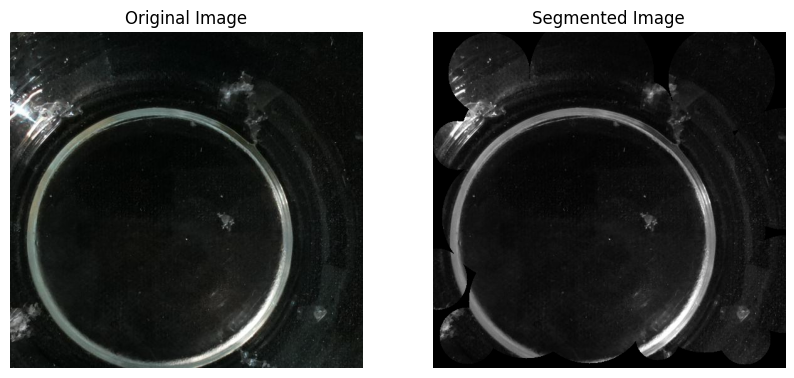

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Detect circles using Hough Circle Transform directly on the grayscale image
circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, 
                           param1=50, param2=30, minRadius=10, maxRadius=100)

# Ensure at least some circles were found
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")

    # Create a mask for the circles
    mask = np.zeros_like(gray_image)

    # Get the coordinates and draw the circles on the mask
    for (x, y, r) in circles:
        cv2.circle(mask, (x, y), r, 255, thickness=-1)

    # Step 3: Extract the region inside the circles
    segmented_image = cv2.bitwise_and(gray_image, gray_image, mask=mask)

    # Step 4: Display the original and segmented image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image, cmap='gray')
    plt.title('Segmented Image')
    plt.axis('off')

    plt.show()
else:
    print("No circles were found.")


C:\Users\dhruv\AppData\Local\Temp\ipykernel_27344\939350673.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  segmented_image[i // 100, i % 100] = cluster_centers[labels[i]]


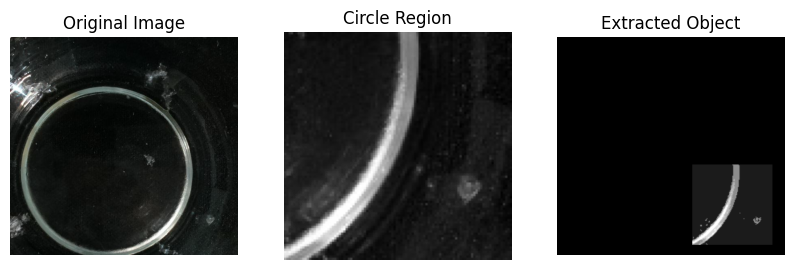

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift

# Step 1: Load the image
image = cv2.imread('Rename.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Detect circles using Hough Circle Transform
circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, 
                           param1=50, param2=30, minRadius=10, maxRadius=100)

# Ensure at least some circle was found
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")

    # Get the first circle's coordinates
    x, y, r = circles[0]

    # Step 3: Extract the region around the circle
    circle_region = gray_image[y - r:y + r, x - r:x + r]
    circle_region = cv2.resize(circle_region, (100, 100))  # Resize for Mean Shift

    # Prepare data for Mean Shift
    reshaped_region = circle_region.reshape((-1, 1))  # Reshape to a 2D array

    # Step 4: Apply Mean Shift clustering
    mean_shift = MeanShift(bandwidth=20)
    mean_shift.fit(reshaped_region)

    # Get labels and cluster centers
    labels = mean_shift.labels_
    cluster_centers = mean_shift.cluster_centers_

    # Step 5: Create a segmented image
    segmented_image = np.zeros_like(circle_region)

    # Map each pixel in the reshaped_region to the corresponding pixel in segmented_image
    for i in range(len(labels)):
        segmented_image[i // 100, i % 100] = cluster_centers[labels[i]]

    # Resize back to original circle size
    segmented_image = cv2.resize(segmented_image, (2*r, 2*r))

    # Create a mask to extract the object
    mask = np.zeros_like(gray_image)
    mask[y - r:y + r, x - r:x + r] = segmented_image

    # Step 6: Display the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(circle_region, cmap='gray')
    plt.title('Circle Region')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('Extracted Object')
    plt.axis('off')

    plt.show()
else:
    print("No circles were found.")


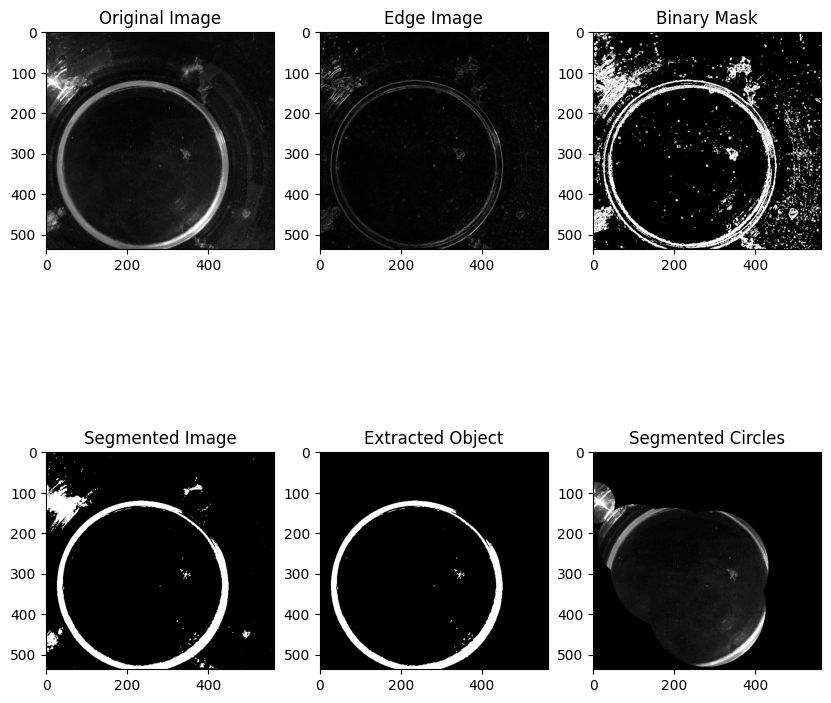

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_edge_image(img, method='gradient'):
    if method == 'gradient':
        grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        edge_img = np.sqrt(grad_x**2 + grad_y**2)
    elif method == 'laplacian':
        edge_img = cv2.Laplacian(img, cv2.CV_64F)
        edge_img = np.abs(edge_img)
    else:
        raise ValueError("Unknown method. Use 'gradient' or 'laplacian'.")
    return edge_img

def threshold_image(edge_img, T):
    _, binary_img = cv2.threshold(edge_img, T, 255, cv2.THRESH_BINARY)
    return binary_img.astype(np.uint8)

def get_strong_edge_pixels(img, binary_mask):
    return img[binary_mask == 255]

def compute_histogram(strong_edges):
    hist, _ = np.histogram(strong_edges, bins=256, range=(0, 256))
    return hist

def global_segmentation(img):
    _, segmented_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return segmented_img

def extract_object(segmented_img):
    _, thresh = cv2.threshold(segmented_img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    
    mask = np.zeros_like(segmented_img)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    extracted_object = cv2.bitwise_and(segmented_img, segmented_img, mask=mask)
    return extracted_object

# Load the image
image = cv2.imread('Rename.jpg')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to smooth the image
blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)

# Step 1: Edge Detection
edge_img = compute_edge_image(gray_image, method='gradient')
T = 50  # You can adjust this value
binary_img = threshold_image(edge_img, T)
strong_edges = get_strong_edge_pixels(gray_image, binary_img)
hist = compute_histogram(strong_edges)
segmented_img = global_segmentation(gray_image)
extracted_object = extract_object(segmented_img)

# Step 2: Detect circles using Hough Circle Transform
circles = cv2.HoughCircles(blurred_image, 
                           cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                           param1=50, param2=30, minRadius=50, maxRadius=150)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")

    # Create a mask for the circles
    mask = np.zeros_like(gray_image)

    # Draw the detected circles on the mask
    for (x, y, r) in circles:
        cv2.circle(mask, (x, y), r, 255, thickness=-1)

    # Step 3: Extract the region inside the circle
    segmented_image_circles = cv2.bitwise_and(gray_image, gray_image, mask=mask)

    # Step 4: Display the results
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 3, 1), plt.imshow(gray_image, cmap='gray'), plt.title('Original Image')
    plt.subplot(2, 3, 2), plt.imshow(edge_img, cmap='gray'), plt.title('Edge Image')
    plt.subplot(2, 3, 3), plt.imshow(binary_img, cmap='gray'), plt.title('Binary Mask')
    plt.subplot(2, 3, 4), plt.imshow(segmented_img, cmap='gray'), plt.title('Segmented Image')
    plt.subplot(2, 3, 5), plt.imshow(extracted_object, cmap='gray'), plt.title('Extracted Object')
    plt.subplot(2, 3, 6), plt.imshow(segmented_image_circles, cmap='gray'), plt.title('Segmented Circles')
    plt.show()
    
else:
    print("No circles were found")

# Additional processing with morphological operations
img_color = cv2.imread('Rename.jpg')
gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
eroded = cv2.erode(thresh, kernel, iterations=1)
dilated = cv2.dilate(eroded, kernel, iterations=1)

contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

mask = np.zeros_like(img_color)
cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), thickness=-1)
extracted_object_morph = cv2.bitwise_and(img_color, mask)

# Display the extracted object using morphological operations
cv2.imshow('Extracted Object (Morphological)', extracted_object_morph)
cv2.waitKey(0)
cv2.destroyAllWindows()
